In [ ]:
!pip install --user opencv-contrib-python

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
import os
from skimage.filters import gaussian, threshold_otsu, threshold_mean
from skimage.color import rgb2gray
from intelligent_placer_lib.modules import detection
from skimage.morphology import binary_opening, binary_closing
from skimage.measure import regionprops
from skimage import measure

In [2]:
ITEMS_PATH = "./items"
DATASET_PATH = "./test_input/images"
MASKS_PATH = "./masks"

In [3]:
# функция, возвращающая массив обрезанных изображений предметов
def get_objects_boxes(img_path):
    img = imread(img_path)
    # предобработка изображения
    img = cv2.resize(img, (int(img.shape[1] / 2), int(img.shape[0] / 2)))
    img_blur_gray = rgb2gray(gaussian(img, sigma=1.5, channel_axis=True))
    
    objects_rect = detection.find_objects_area(img_blur_gray)
    
    # обрезаем изображение
    min_y, min_x, max_y, max_x = objects_rect
    objects_image = img[min_y:max_y, min_x:max_x]
    objects_image_gray = img_blur_gray[min_y:max_y, min_x:max_x]
    
    # еще раз используем бинаризацию на вырезанных предметах, чтобы отделить их друг от друга
    threshold_img = threshold_mean(objects_image_gray)
    result_image = objects_image_gray <= threshold_img
    result_image = binary_closing(result_image, footprint=np.ones((15, 15)))

    # получаем массив баундинг боксов
    result_boxes = []
    labels = measure.label(result_image)
    props = regionprops(labels)
    for prop in props:
        if prop.area > 5000 and prop.bbox[1] > 5 and prop.bbox[3] < result_image.shape[1] - 5:
            box_min_y, box_min_x, box_max_y, box_max_x = prop.bbox
            box_min_y, box_min_x, box_max_y, box_max_x = max(box_min_y - 30, 0), max(box_min_x - 30, 0), min(box_max_y + 30, img.shape[1]), min(box_max_x + 30,  img.shape[0])
            result_boxes.append([box_min_y, box_min_x, box_max_y, box_max_x])
    # получаем отдельные предметы
    objects = []
    for box in result_boxes:
        box_min_y, box_min_x, box_max_y, box_max_x = box
        objects.append(objects_image[box_min_y:box_max_y, box_min_x:box_max_x])
    return objects

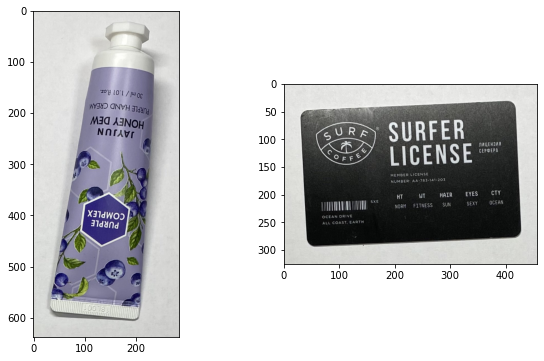

In [30]:
img_path = os.path.join(DATASET_PATH, "30.jpg")
objects = get_objects_boxes(img_path)
if not objects is None:
    ig, ax = plt.subplots(1, len(objects), figsize=(len(objects) * 5, 6))
    for i, object in enumerate(objects):
        ax[i].imshow(object)

In [61]:
def correct_image(image, kernel_size=(5, 5), sigma=1.5, amount=6, threshold=0.01, brightness=100):
    # повышаем яркость изображения на значение 'brightness'
    image = np.where((255 - image) < brightness, 255, image + brightness)  
    # повышаем четкость изображения, используя unsharp mask
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

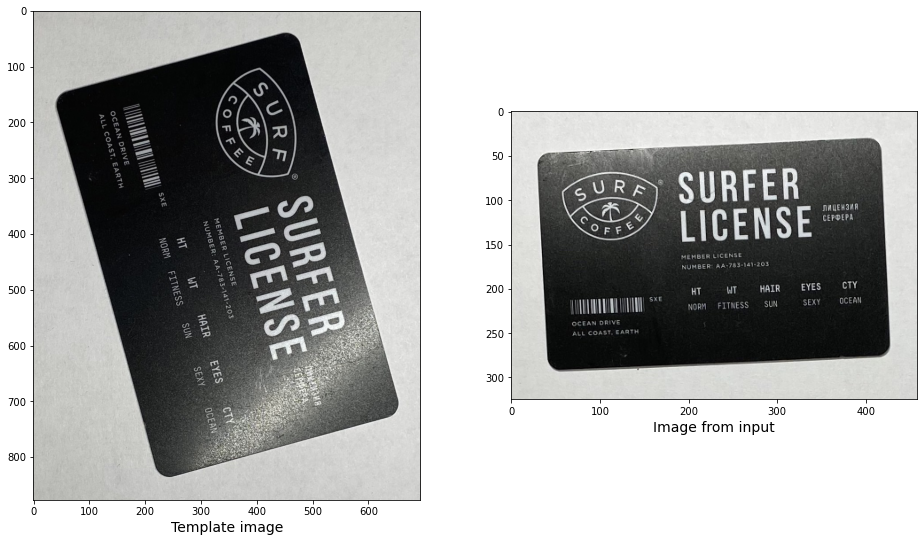

In [6]:
template_img = imread(os.path.join(MASKS_PATH, "card.jpg"))
template_img_gray = cv2.cvtColor(template_img, cv2.COLOR_RGB2GRAY)
# trainImg_gray = correct_image(trainImg_gray)

input_img = objects[1]
input_img_gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
# queryImg_gray = correct_image(queryImg_gray)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(template_img, cmap="gray")
ax1.set_xlabel("Template image", fontsize=14)
ax2.imshow(input_img, cmap="gray")
ax2.set_xlabel("Image from input", fontsize=14)

plt.show()

In [7]:
def detectAndDescribe(image):    
    detector = cv2.ORB_create()
    kps = detector.detect(image, None)
    descriptor = cv2.xfeatures2d.BEBLID_create(1)
    (kps, features) = descriptor.compute(image, kps)
    return (kps, features)

In [8]:
kpsA, featuresA = detectAndDescribe(template_img_gray)
kpsB, featuresB = detectAndDescribe(input_img_gray)

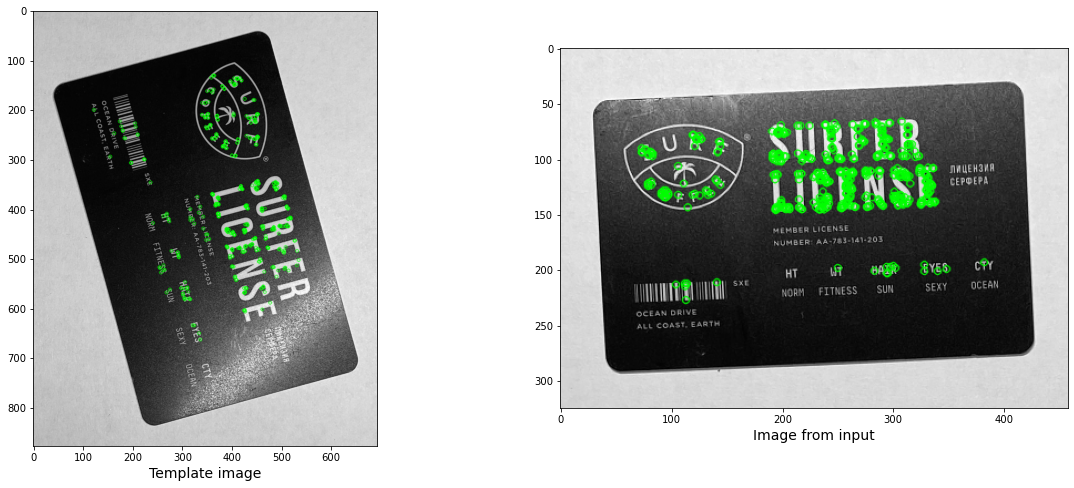

In [9]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(template_img_gray, kpsA, None, color=(0,255,0)))
ax1.set_xlabel("Template image", fontsize=14)
ax2.imshow(cv2.drawKeypoints(input_img_gray, kpsB, None, color=(0,255,0)))
ax2.set_xlabel("Image from input", fontsize=14)

plt.show()

In [10]:
def matchKeyPointsBF(featuresA, featuresB):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)            
    best_matches = bf.match(featuresA, featuresB)
    
    # сортируем дескрипторы в соответствии с расстоянием
    # чем меньше расстояние, тем точнее совпадение
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    
    print("Raw matches (Brute force):", len(rawMatches))
    # возвращаем 130 лучших точек
    return rawMatches[:130]

Raw matches (Brute force): 158


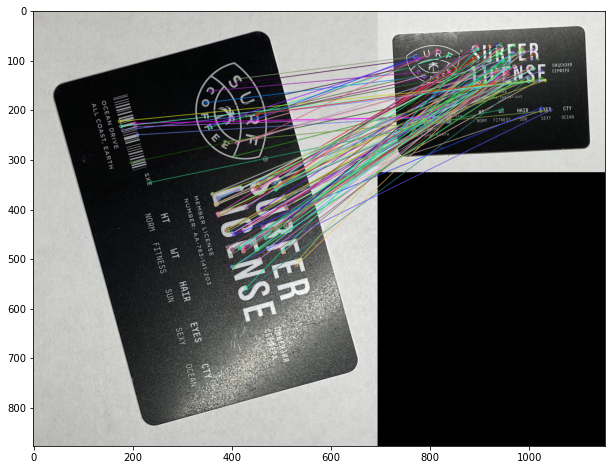

In [11]:
fig = plt.figure(figsize=(20,8))

matches = matchKeyPointsBF(featuresA, featuresB)
img = cv2.drawMatches(template_img, kpsA, input_img, kpsB, matches,
                       None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img)
plt.show()

In [12]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)
        return (matches, H, status)
    else:
        return None

In [13]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 1.21222653e-01  5.33772114e-01 -4.65878356e+01]
 [-5.34177638e-01  1.19479865e-01  2.94932463e+02]
 [ 2.30686692e-05 -1.63568402e-05  1.00000000e+00]]


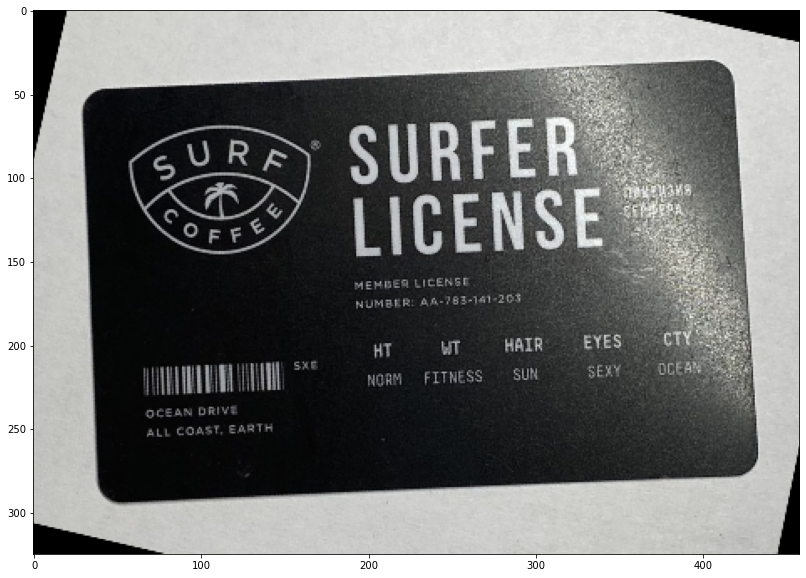

In [14]:
result = cv2.warpPerspective(template_img, H, (input_img.shape[1], input_img.shape[0]))

plt.figure(figsize=(20,10))
plt.imshow(result)
plt.show()

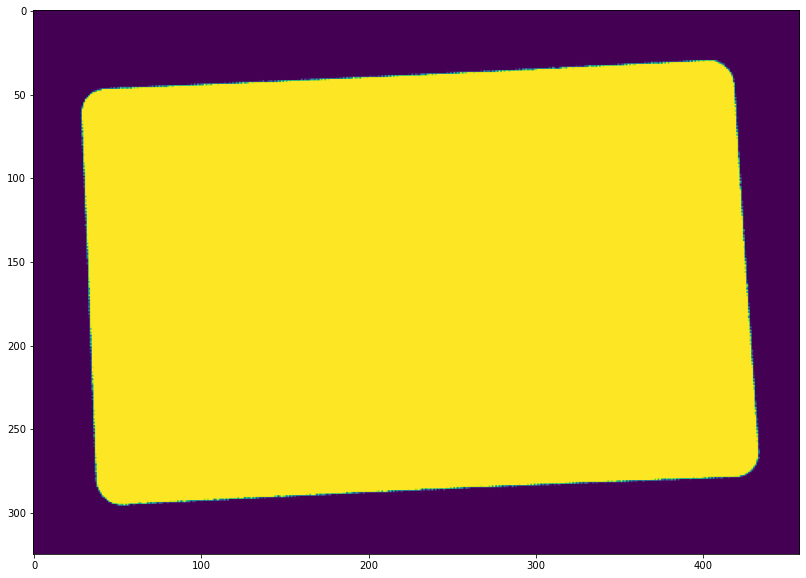

In [15]:
mask = imread(os.path.join(MASKS_PATH, "mask_card.jpg"))
result = cv2.warpPerspective(mask, H, (input_img.shape[1], input_img.shape[0]))
plt.figure(figsize=(20,10))
plt.imshow(result)
plt.show()

In [196]:
def detect_and_describe_key_points(image):    
    detector = cv2.ORB_create(5000)
    kps = detector.detect(image, None)
    descriptor = cv2.xfeatures2d.BEBLID_create(1)
    (kps, features) = descriptor.compute(image, kps)
    return (kps, features)

def match_key_points_bf(featuresA, featuresB):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck=True)            
    best_matches = bf.match(featuresA, featuresB)
    # сортируем дескрипторы в соответствии с расстоянием
    # чем меньше расстояние, тем точнее совпадение
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    return rawMatches

def get_homography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])    
    if len(matches) > 4:
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)
        return (matches, H, status)
    else:
        return None
    
def get_proper_mask(input_img, show=False):
    input_img_gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    kpsB, featuresB = detect_and_describe_key_points(input_img_gray)
    matches_num = []
    masks_names = []
    for img_name in os.listdir(MASKS_PATH):
        if not img_name.startswith("mask_"):
            template_img = imread(os.path.join(MASKS_PATH, img_name))
            template_img_gray = cv2.cvtColor(template_img, cv2.COLOR_RGB2GRAY)
            kpsA, featuresA = detect_and_describe_key_points(template_img_gray)
            matches = match_key_points_bf(featuresA, featuresB)
            matches_num.append(len(matches))
            masks_names.append(img_name)
    mask_name = masks_names[np.asarray(matches_num).argmax()]
    template_img = imread(os.path.join(MASKS_PATH, mask_name))
    template_img_gray = cv2.cvtColor(template_img, cv2.COLOR_RGB2GRAY)
    kpsA, featuresA = detect_and_describe_key_points(template_img_gray)
    matches = match_key_points_bf(featuresA, featuresB)[:130]
    M = get_homography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
    if M is None:
        return None
    (matches, H, status) = M
    
    mask = imread(os.path.join(MASKS_PATH, "mask_" + mask_name))
    result = cv2.warpPerspective(mask, H, (input_img.shape[1], input_img.shape[0]))
    
    if show == True:
        ig, ax = plt.subplots(1, 3, figsize=(15, 6))
        ax[0].set_xlabel("Mask image")
        ax[0].imshow(mask)
        ax[1].set_xlabel("Input image")
        ax[1].imshow(input_img)
        ax[2].set_xlabel("Result mask image")
        ax[2].imshow(result)
        plt.show()
        
    return result

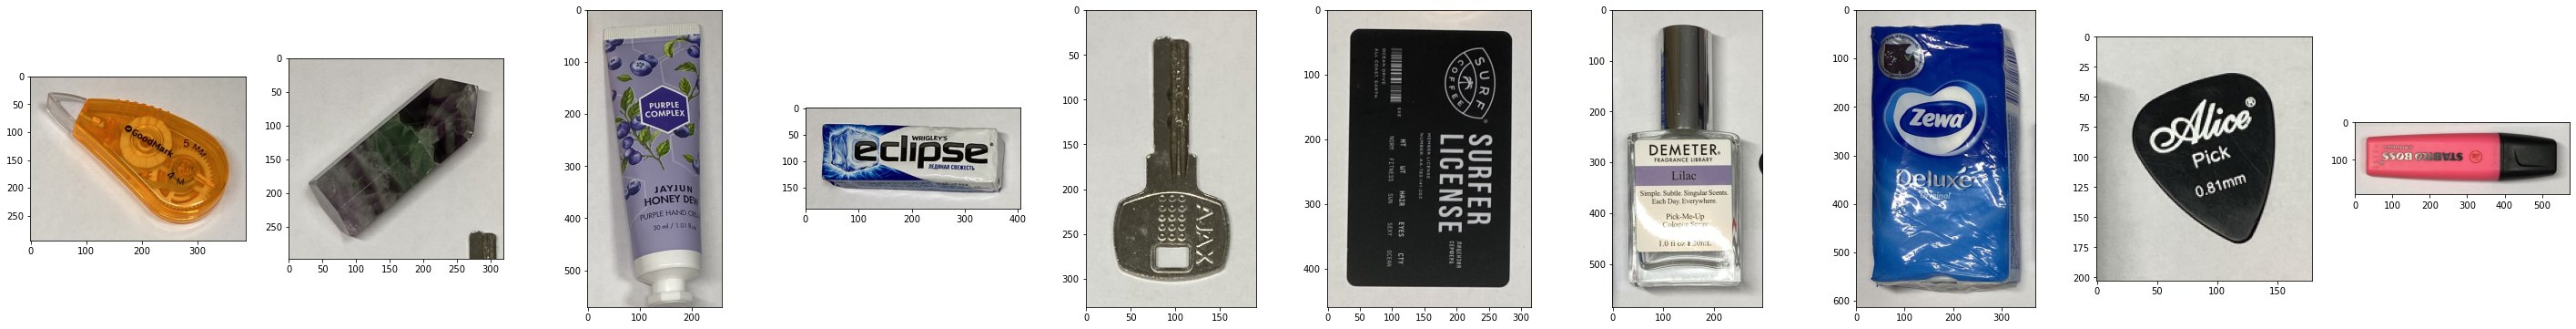

In [197]:
img_path = os.path.join(DATASET_PATH, "23.jpg")
objects = get_objects_boxes(img_path)
if not objects is None:
    ig, ax = plt.subplots(1, len(objects), figsize=(len(objects) * 5, 6))
    if len(objects) > 1:
        for i, object in enumerate(objects):
            ax[i].imshow(object)
    else:
         ax.imshow(objects[0])

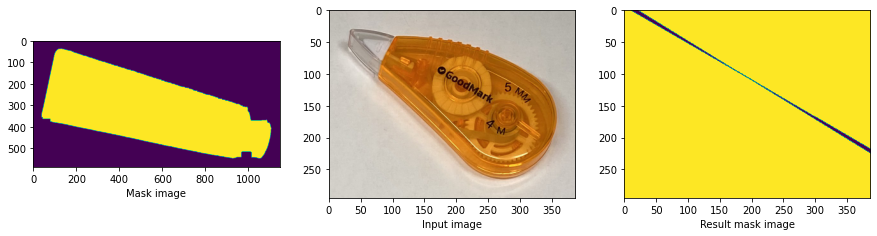

In [198]:
res = get_proper_mask(objects[0], show=True)

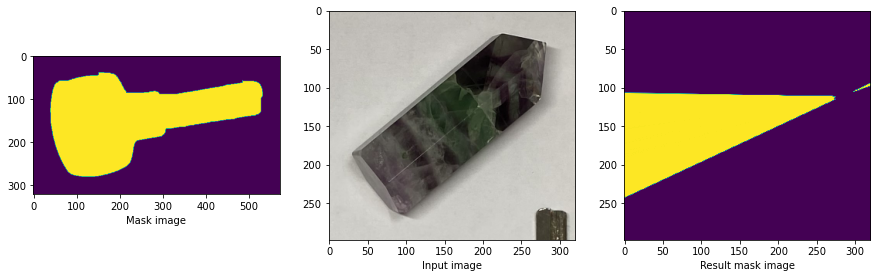

In [199]:
res = get_proper_mask(objects[1], show=True)

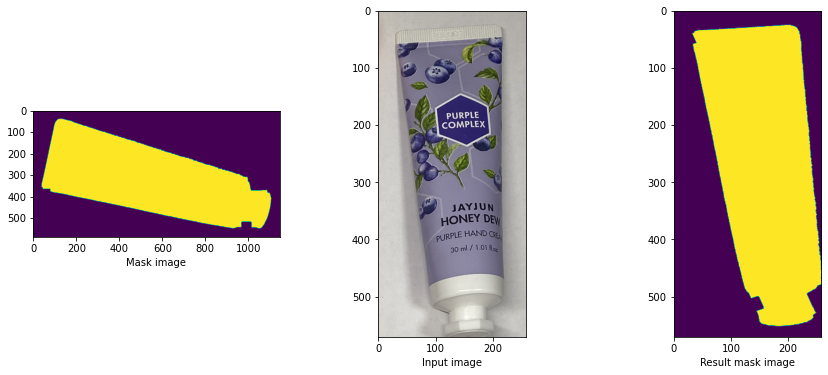

In [200]:
res = get_proper_mask(objects[2], show=True)

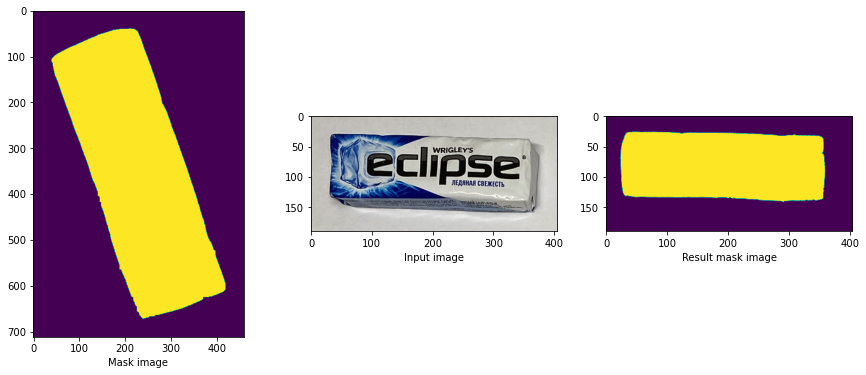

In [201]:
res = get_proper_mask(objects[3], show=True)

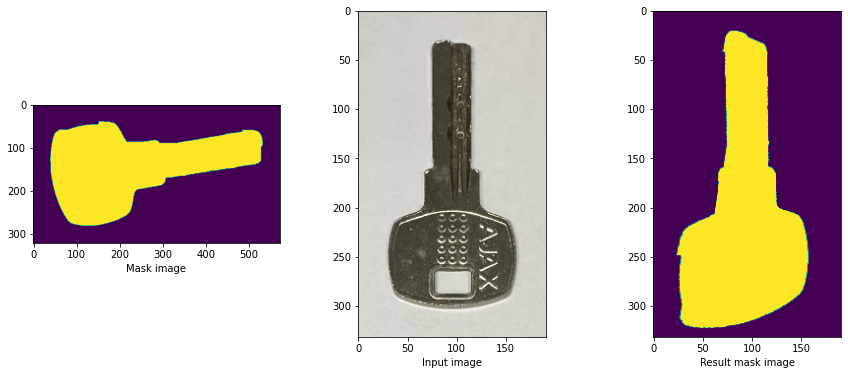

In [202]:
res = get_proper_mask(objects[4], show=True)

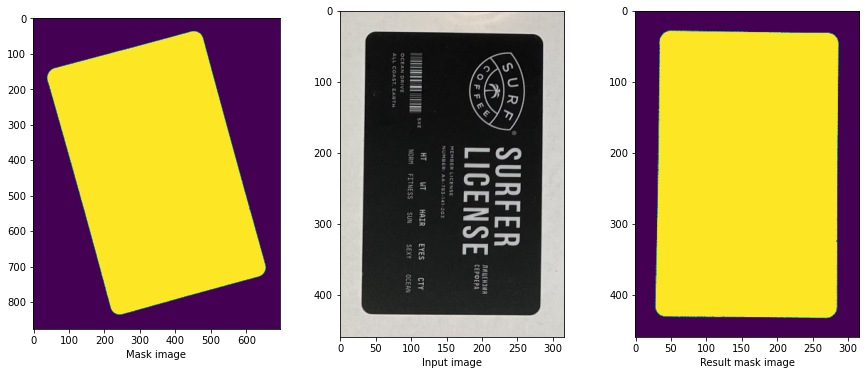

In [203]:
res = get_proper_mask(objects[5], show=True)

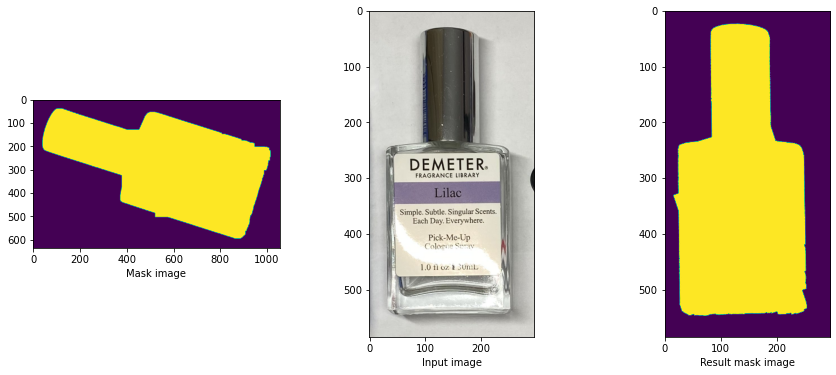

In [204]:
res = get_proper_mask(objects[6], show=True)

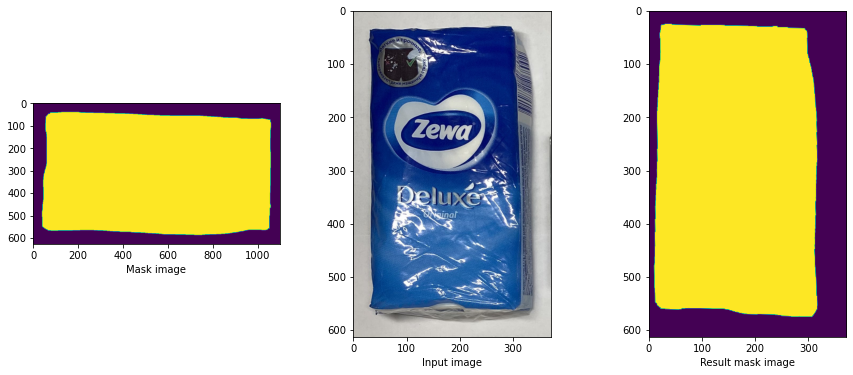

In [205]:
res = get_proper_mask(objects[7], show=True)

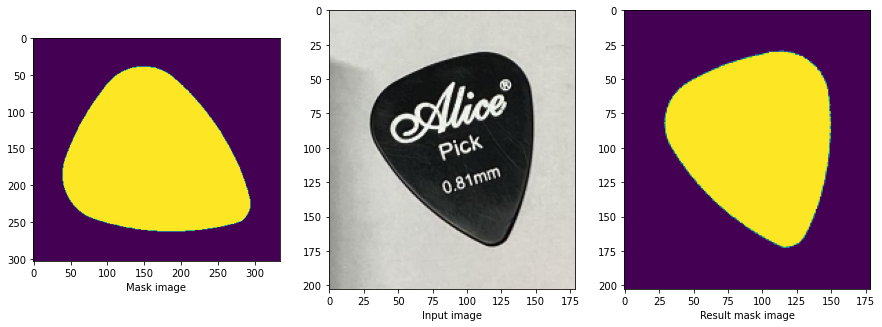

In [206]:
res = get_proper_mask(objects[8], show=True)

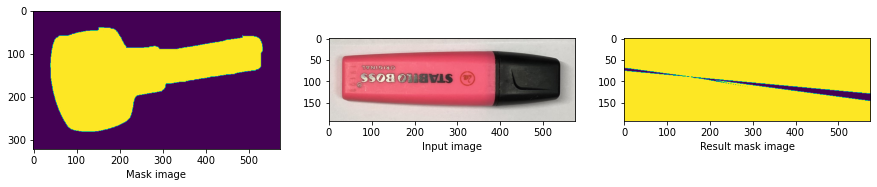

In [207]:
res = get_proper_mask(objects[9], show=True)